### Edgar Moises Hernandez-Gonzalez
#### 29/04/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Resize proporcional de 352x125
##### Data Augmentation
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (cohen_kappa_score, confusion_matrix,
                             roc_auc_score, roc_curve)
import pywt
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/MI-EEG-ID-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/MI-EEG-ID-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE-DWT-Binaria/Etiquetas-ID-A01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE-DWT-Binaria/Etiquetas-ID-A01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 22000)
(144, 22000)
(144, 1)
(144, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 144
n_samples_test : 144


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 2


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (125, 352) #ancho, alto
  datos = np.zeros((144,352,125))
  temporal = np.zeros((2816,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

0
100


In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

0
100


In [0]:
print(x_train.shape)
print(x_test.shape)

(144, 352, 125)
(144, 352, 125)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

50.80911524871337
36.526917436588306
0.0016808164126656904
0.0014808908865048041
3.6882503387977734
3.543660008619964


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 51.0
x_test /= 51.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9962572
0.71621406
3.2957185e-05
2.9037077e-05
0.07231866
0.06948353


In [0]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(144, 352, 125, 1)
(144, 352, 125, 1)


In [0]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_CWTDA09.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(8, (3,3), activation='relu', input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  1.2908443609873455
accuracy:  0.6458333134651184
kappa:  0.29166666666666663
confusion matrix:
 [[42 30]
 [21 51]]
AUC 0.7467206790123456


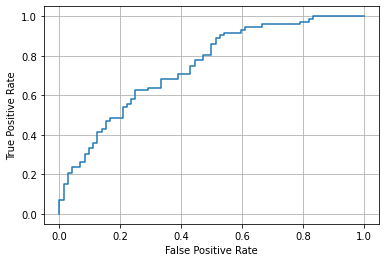

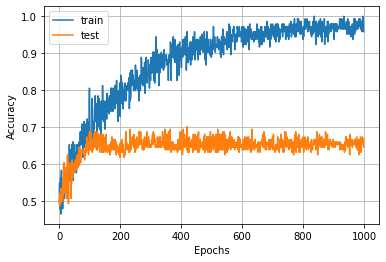

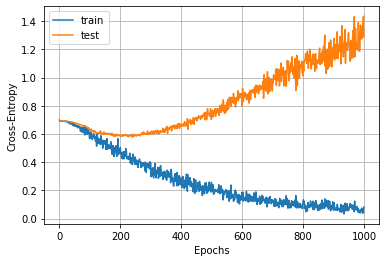

Iteration: 2
loss:  1.1466118097305298
accuracy:  0.6319444179534912
kappa:  0.26388888888888884
confusion matrix:
 [[47 25]
 [28 44]]
AUC 0.7488425925925926


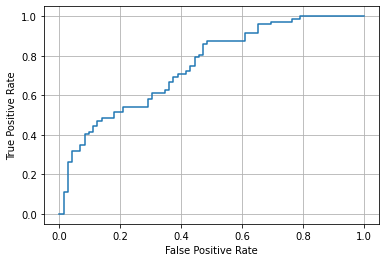

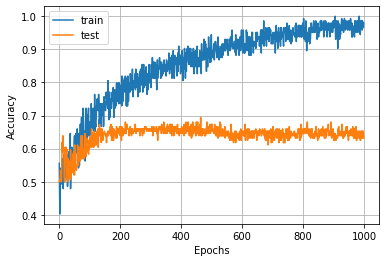

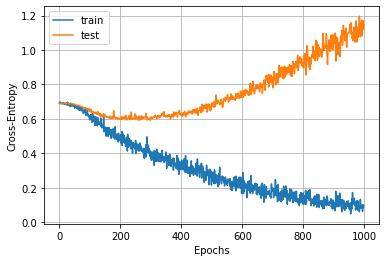


Resultados:
loss: [1.2908443609873455, 1.1466118097305298]
accuracy: [0.6458333134651184, 0.6319444179534912]
kappa: [0.29166666666666663, 0.26388888888888884]


In [20]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0) #, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades)

  print("AUC", auc)
  plt.plot(fpr, tpr)
  plt.grid()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 350, 123, 8)       80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 175, 61, 8)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 173, 59, 8)        584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 86, 29, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 84, 27, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 42, 13, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4368)             

In [22]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6389
std: (+/- 0.0069)
Mean Kappa: 0.2778
std: (+/- 0.0139)
Max Accuracy: 0.6458
Max Kappa: 0.2917
